In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

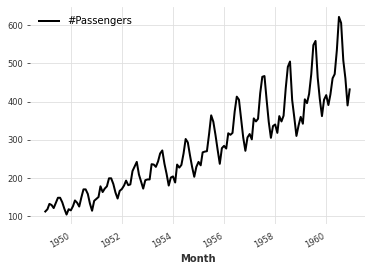

In [2]:
series = AirPassengersDataset().load()
series.plot()

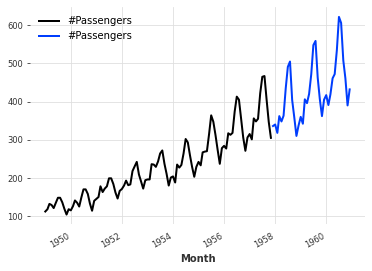

In [3]:
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

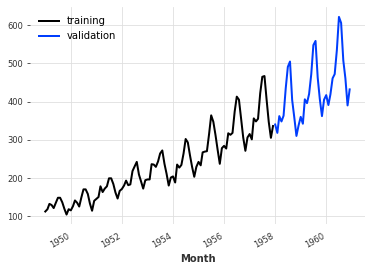

In [4]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")



/home/cboettig/.pyenv/versions/3.7.9/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


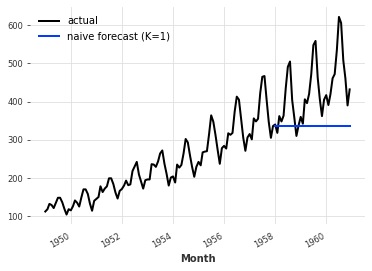

In [5]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

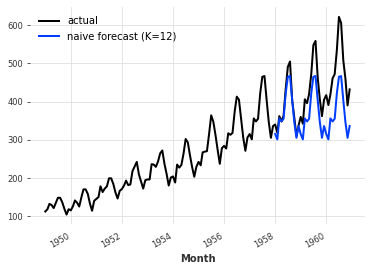

In [6]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")



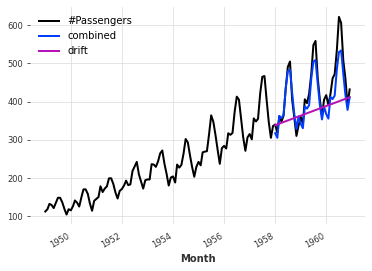

In [7]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")



In [8]:
import darts.metrics

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        darts.metrics.mape(series, combined_forecast)
    )
)



Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


# Probablistic Forecasts

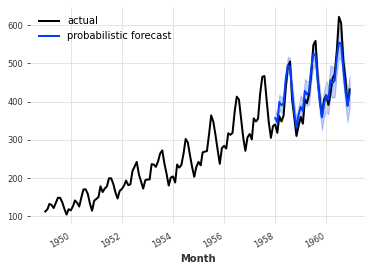

In [9]:
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()



In [10]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood


model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
    torch_device_str = "cuda"
)
model.trainer_params


[2022-03-21 20:37:43,418] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
[2022-03-21 20:37:43,418] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags


{'accelerator': 'gpu',
 'gpus': -1,
 'auto_select_gpus': True,
 'logger': False,
 'max_epochs': 100,
 'check_val_every_n_epoch': 10,
 'enable_checkpointing': False,
 'callbacks': []}

In [11]:

from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
train_scaled = scaler.fit_transform(train)


In [12]:
model.fit(train_scaled, epochs=400, verbose=True)

[2022-03-21 20:37:43,652] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-03-21 20:37:43,652] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-03-21 20:37:43,674] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 3
[2022-03-21 20:37:43,674] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 3
[2022-03-21 20:37:43,677] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-21 20:37:43,677] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-21 20:37:43,679] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progres

Epoch 399: 100%|██████████| 3/3 [00:00<00:00, 103.67it/s, loss=-1.83]  


In [16]:
pred = model.predict(n=36, num_samples=500)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3it [00:00, ?it/s]


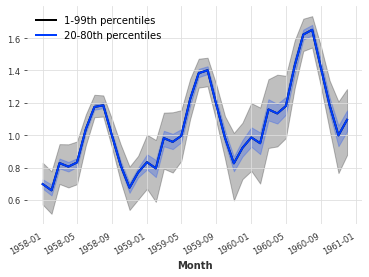

In [17]:

pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

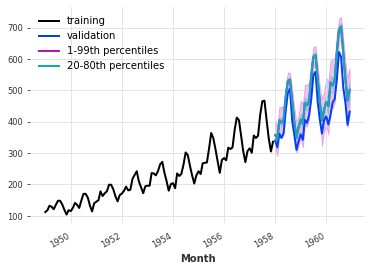

In [18]:
train.plot(label="training")
val.plot(label="validation")
pred = scaler.inverse_transform(pred)
pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")
